## `STEP 1: PRE-PROCESSING`

📌 Importing necessary libraries

In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap
import random
from protree.explainers import G_KM
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
shap.initjs()

c:\Users\joasi\Documents\PP\SEM_5\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📌 Read our data

In [2]:
df_file = pd.read_csv('weather_classification_data.csv')
df_file.head() 

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


📌 Getting 1000 first rows

In [3]:
num_rows = df_file.shape[0]
print(f"Number of rows: {num_rows}")

Number of rows: 13200


In [4]:
# bc of many rows we take only first 1000 rows
df = df_file.iloc[:2000]


📌 Check for Null Values in the Data

In [5]:
df.isnull().sum()


Temperature             0
Humidity                0
Wind Speed              0
Precipitation (%)       0
Cloud Cover             0
Atmospheric Pressure    0
UV Index                0
Season                  0
Visibility (km)         0
Location                0
Weather Type            0
dtype: int64

📌 Check basic information about numeric columns in the Data

In [6]:
df.describe()

,Temperature,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km)
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,19.015000,68.548500,9.581000,53.670500,1006.052435,3.932500,5.351750
std,16.860098,20.443596,6.813913,32.199353,36.574241,3.796861,3.151406
min,-24.000000,20.000000,0.000000,0.000000,800.230000,0.000000,0.000000
25%,4.000000,57.000000,4.500000,19.000000,994.627500,1.000000,3.000000
50%,21.000000,70.000000,8.500000,57.000000,1007.745000,3.000000,5.000000
75%,30.000000,83.000000,13.500000,83.000000,1016.925000,6.000000,7.500000
max,91.000000,109.000000,47.000000,109.000000,1196.030000,14.000000,19.000000


📌 Make Discretization in the Data

In [7]:
k_bins = 3
labels = ["low_temperature", "medium_temperature", "high_temperature"]
df['Temperature'] = pd.cut(df['Temperature'], bins=k_bins, labels=labels)

df.head()

C:\Users\joasi\AppData\Local\Temp\ipykernel_37128\4058179103.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Temperature'] = pd.cut(df['Temperature'], bins=k_bins, labels=labels)


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,low_temperature,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,medium_temperature,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,medium_temperature,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,medium_temperature,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,medium_temperature,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


📌 Make Encoding in the Data

In [8]:
# Getting our Data and Target Value separately
df_X = df.drop(['Weather Type'], axis = 1)
df_y = df[['Weather Type']]

df_X

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location
0,low_temperature,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland
1,medium_temperature,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland
2,medium_temperature,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain
3,medium_temperature,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal
4,medium_temperature,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain
...,...,...,...,...,...,...,...,...,...,...
1995,medium_temperature,43,0.0,6.0,clear,1015.69,10,Summer,7.0,coastal
1996,low_temperature,89,6.5,86.0,overcast,992.27,2,Summer,1.5,coastal
1997,medium_temperature,74,9.0,31.0,overcast,1014.22,4,Spring,8.5,coastal
1998,medium_temperature,45,2.0,1.0,clear,1025.05,5,Winter,8.0,coastal


In [9]:
# Making encoding on Data
df_X_encoded = pd.get_dummies(df_X)

# Changing bool values to int
bool_columns = df_X_encoded.select_dtypes(include=['bool']).columns  
df_X_encoded[bool_columns] = df_X_encoded[bool_columns].astype(int)  

df_X_encoded.head()

,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature_low_temperature,Temperature_medium_temperature,Temperature_high_temperature,Cloud Cover_clear,Cloud Cover_cloudy,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain
0,73,9.5,82.0,1010.82,2,3.5,1,0,0,0,0,0,1,0,0,0,1,0,1,0
1,96,8.5,71.0,1011.43,7,10.0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
2,64,7.0,16.0,1018.72,5,5.5,0,1,0,1,0,0,0,0,1,0,0,0,0,1
3,83,1.5,82.0,1026.25,7,1.0,0,1,0,1,0,0,0,0,1,0,0,1,0,0
4,74,17.0,66.0,990.67,1,2.5,0,1,0,0,0,1,0,0,0,0,1,0,0,1


In [10]:
# Making encoding on Target Value
label_encoder = LabelEncoder()
df_y.loc[:, 'Weather Type encoded'] = label_encoder.fit_transform(df_y['Weather Type'])

y = df_y['Weather Type encoded']
df_y.head()

C:\Users\joasi\AppData\Local\Temp\ipykernel_37128\3951848184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_y.loc[:, 'Weather Type encoded'] = label_encoder.fit_transform(df_y['Weather Type'])


,Weather Type,Weather Type encoded
0,Rainy,1
1,Cloudy,0
2,Sunny,3
3,Sunny,3
4,Rainy,1


## `STEP 2: CREATING A MODEL`


📌 Splitting the dataset into training (70%) and testing (30%) sets and build two models: an XGBoost Classifier and a Random Forest Classifier.

In [11]:
# XGBoost Classifier
X_train, X_test, y_train, y_test = train_test_split(df_X_encoded, y, test_size=0.3, random_state=42)

model_XGBoost = XGBClassifier(random_state=42).fit(X_train, y_train)

y_pred = model_XGBoost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'XGBoost Accuracy: {accuracy:.4f}')

XGBoost Accuracy: 0.8867


In [12]:
#Random Forest Classifier
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df_X_encoded, y, test_size=0.3, random_state=42)

model_RF_Classifier = RandomForestClassifier(random_state=42).fit(X_train_2, y_train_2)

y_pred = model_RF_Classifier.predict(X_test_2)
accuracy = accuracy_score(y_test_2, y_pred)
print(f'Random Forest Accuracy: {accuracy:.4f}')

Random Forest Accuracy: 0.9000


## STEP 2: `FEATUE IMPORTANCE` - FIRST EXPLANATORY METHOD

In [13]:
# XGBoost Classifier with SHAP

explainer = shap.Explainer(model_XGBoost)
shap_values = explainer(X_test)

probs = model_XGBoost.predict_proba(X_test)
class_labels = label_encoder.classes_
print(class_labels)

['Cloudy' 'Rainy' 'Snowy' 'Sunny']


[2.2460599e-04 9.9942446e-01 2.1310622e-04 1.3782497e-04] 1
Waterfall plot for sample 0, class Rainy


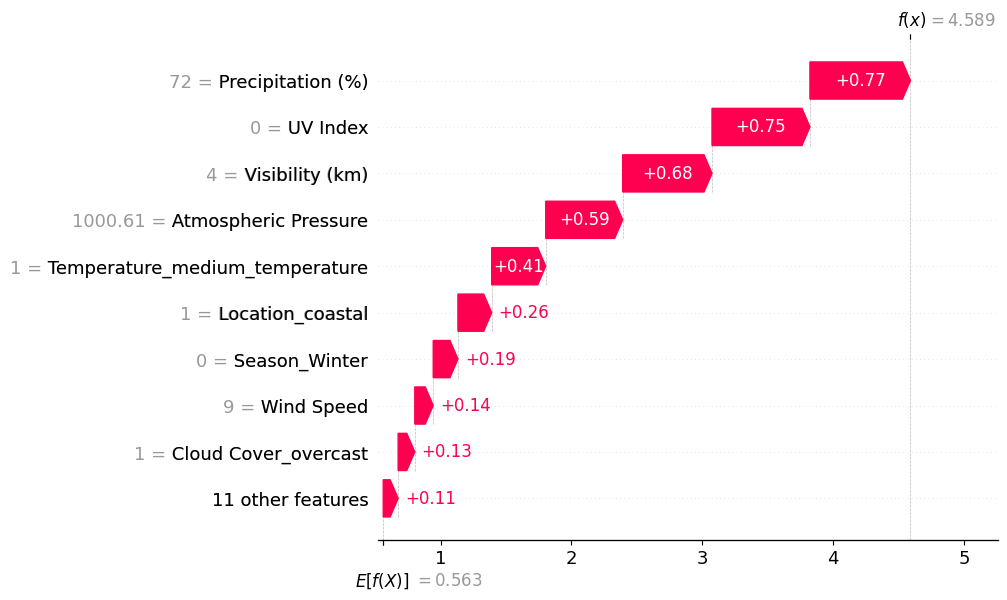

[9.9948525e-01 8.2925217e-05 1.9079765e-05 4.1272040e-04] 0
Waterfall plot for sample 1, class Cloudy


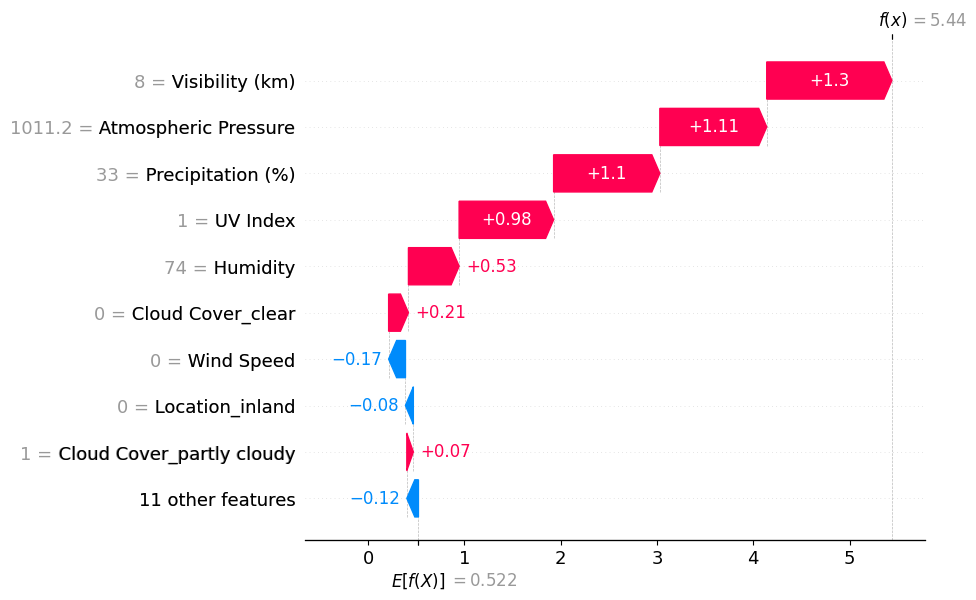

[2.05235010e-05 1.04623294e-04 9.99866128e-01 8.76395279e-06] 2
Waterfall plot for sample 2, class Snowy


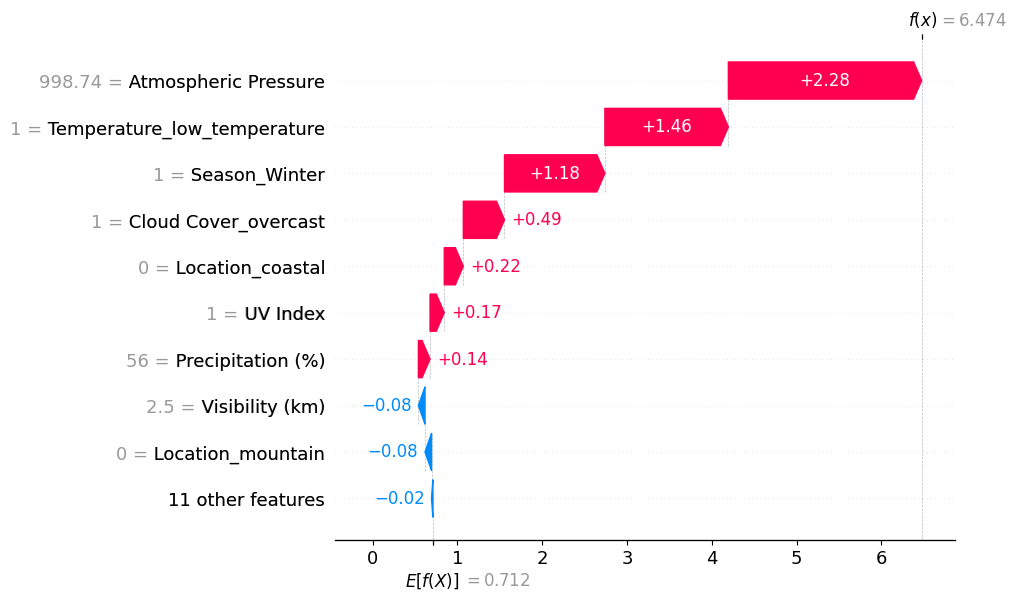

[0.97724503 0.01138835 0.00112266 0.01024394] 0
Waterfall plot for sample 3, class Cloudy


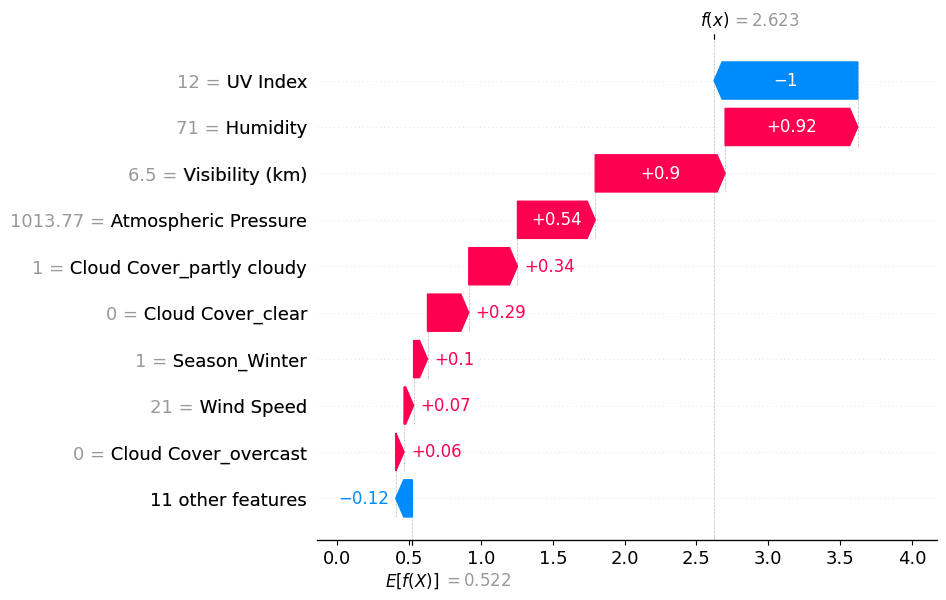

[8.3440842e-05 9.9981028e-01 5.8439498e-05 4.7902384e-05] 1
Waterfall plot for sample 4, class Rainy


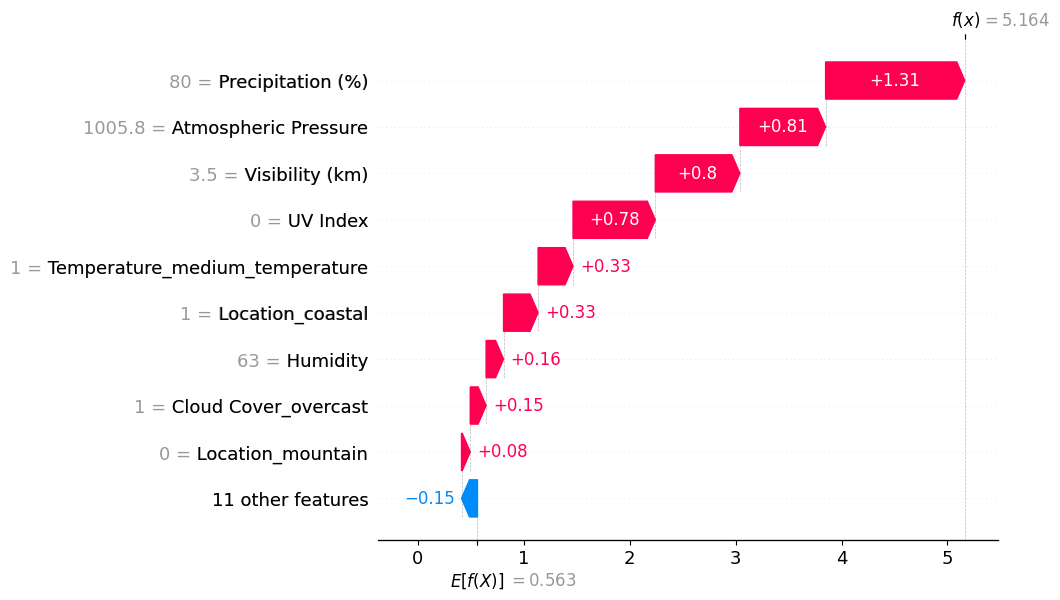

[9.9899298e-01 5.6154805e-04 1.4272895e-04 3.0274529e-04] 0
Waterfall plot for sample 5, class Cloudy


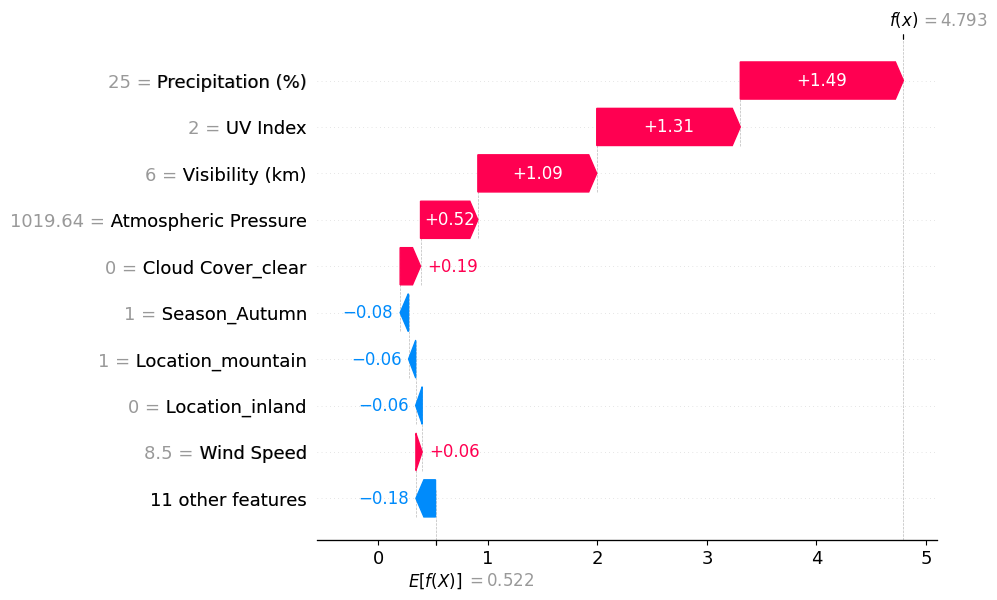

[2.3377412e-04 2.7820877e-05 9.1894697e-05 9.9964654e-01] 3
Waterfall plot for sample 6, class Sunny


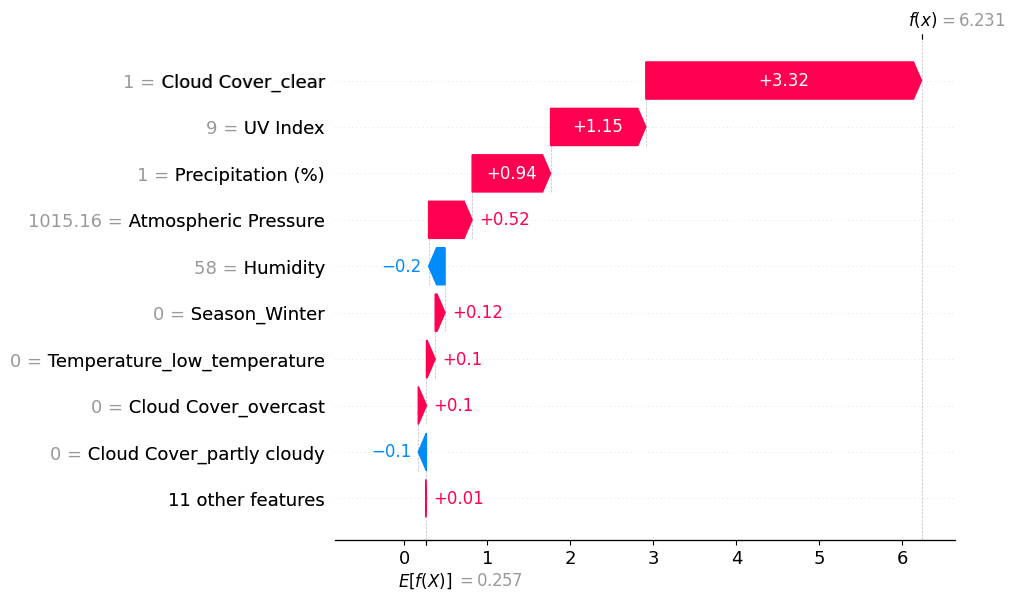

[9.9885428e-01 1.0041286e-03 7.7848206e-05 6.3687155e-05] 0
Waterfall plot for sample 7, class Cloudy


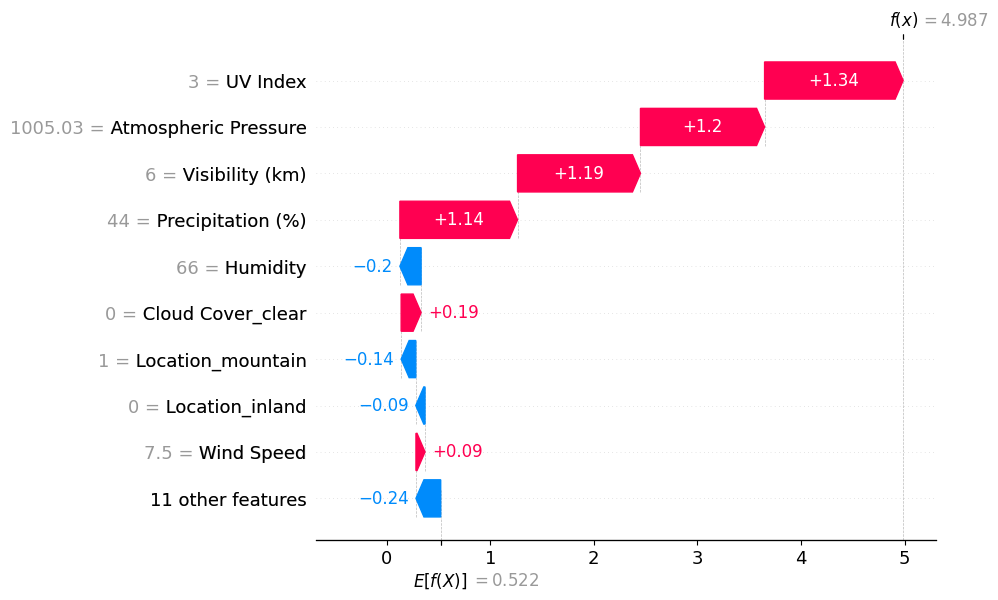

[7.3431307e-05 9.9867260e-01 1.2007446e-03 5.3195570e-05] 1
Waterfall plot for sample 8, class Rainy


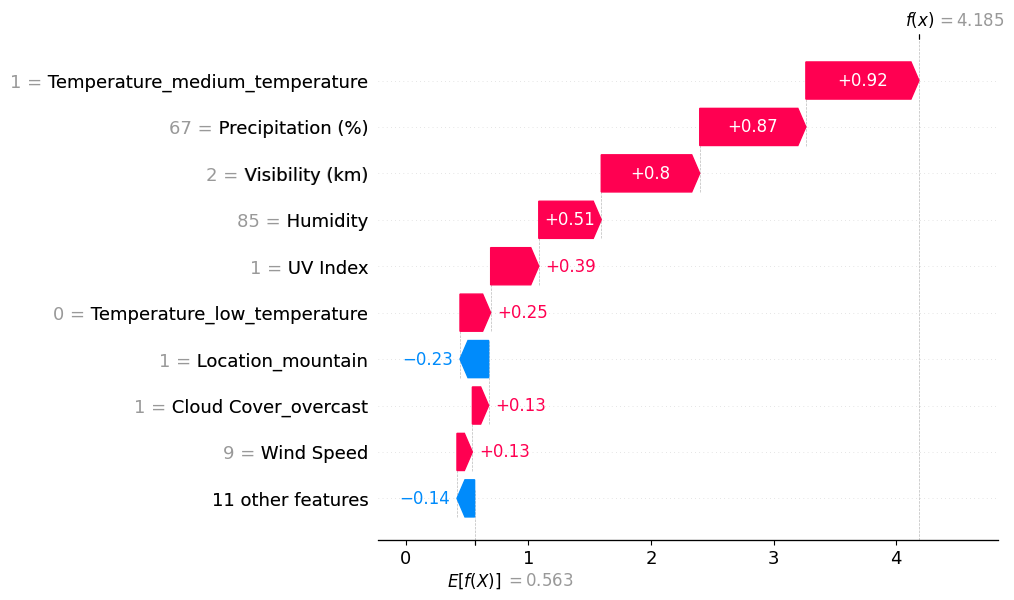

[7.2667608e-05 7.8612812e-02 9.2124546e-01 6.8993089e-05] 2
Waterfall plot for sample 9, class Snowy


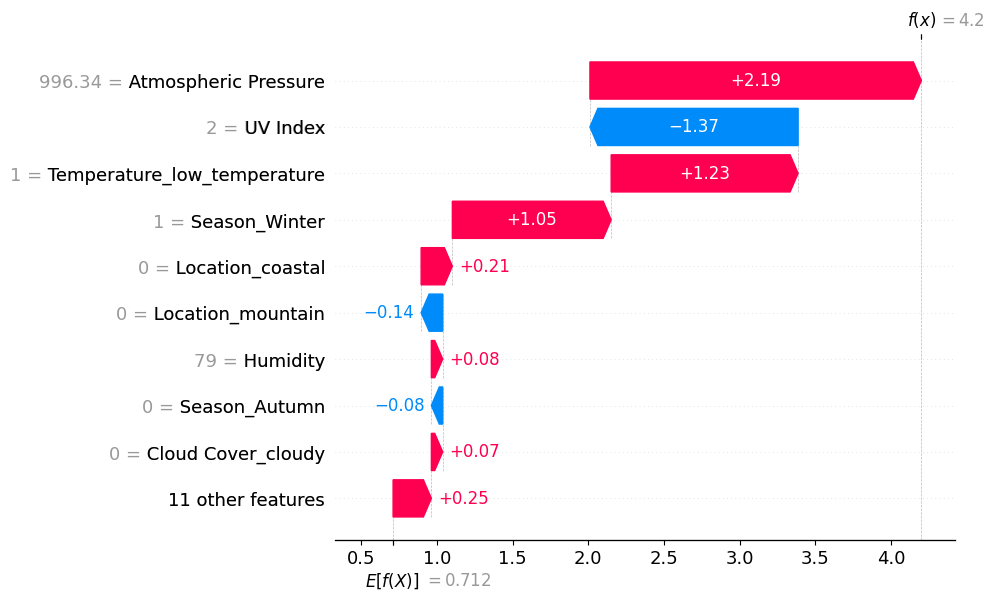

[9.7732383e-01 2.1202926e-02 2.1535999e-04 1.2578495e-03] 0
Waterfall plot for sample 10, class Cloudy


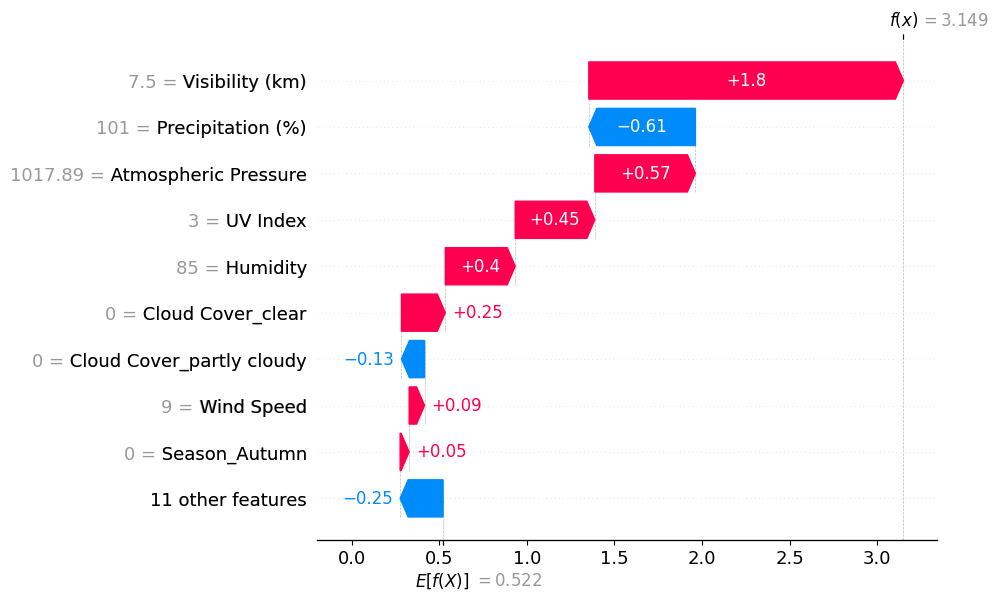

[0.0432962  0.8237904  0.08991924 0.0429942 ] 1
Waterfall plot for sample 11, class Rainy


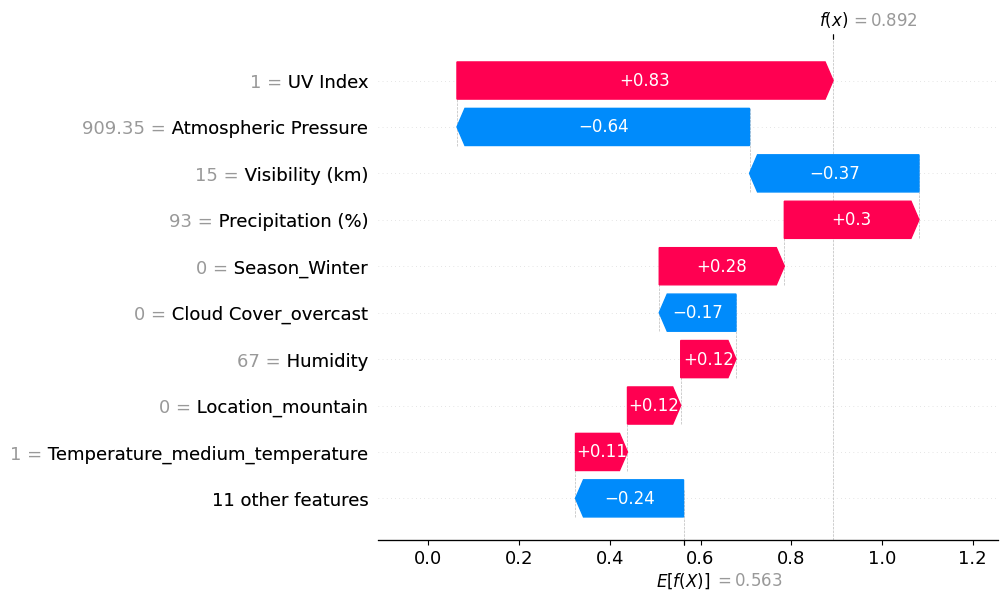

[9.9985552e-01 7.9066267e-05 4.1734151e-05 2.3610308e-05] 0
Waterfall plot for sample 12, class Cloudy


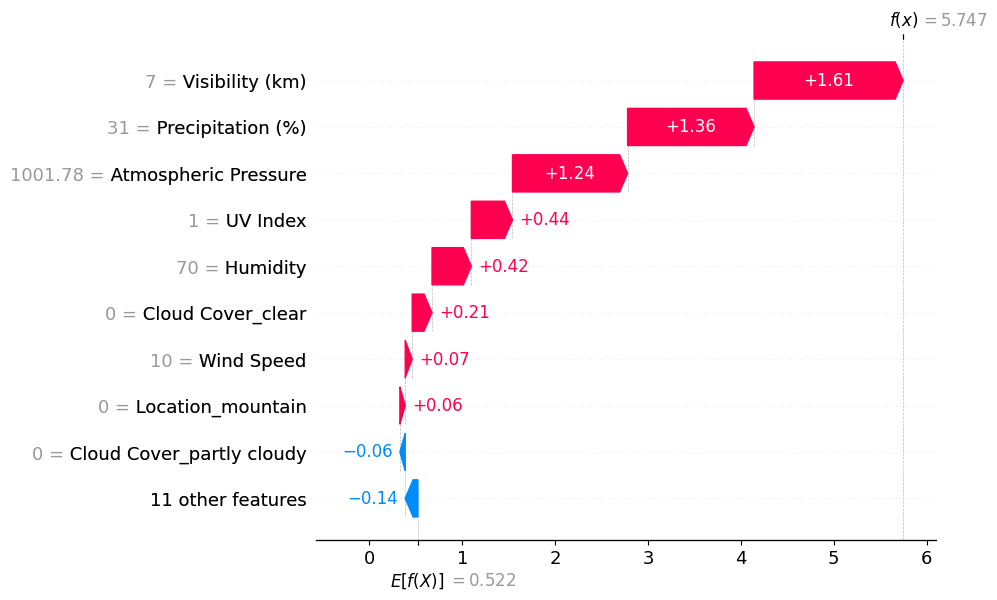

[0.8472194  0.07037603 0.01258811 0.06981647] 0
Waterfall plot for sample 13, class Cloudy


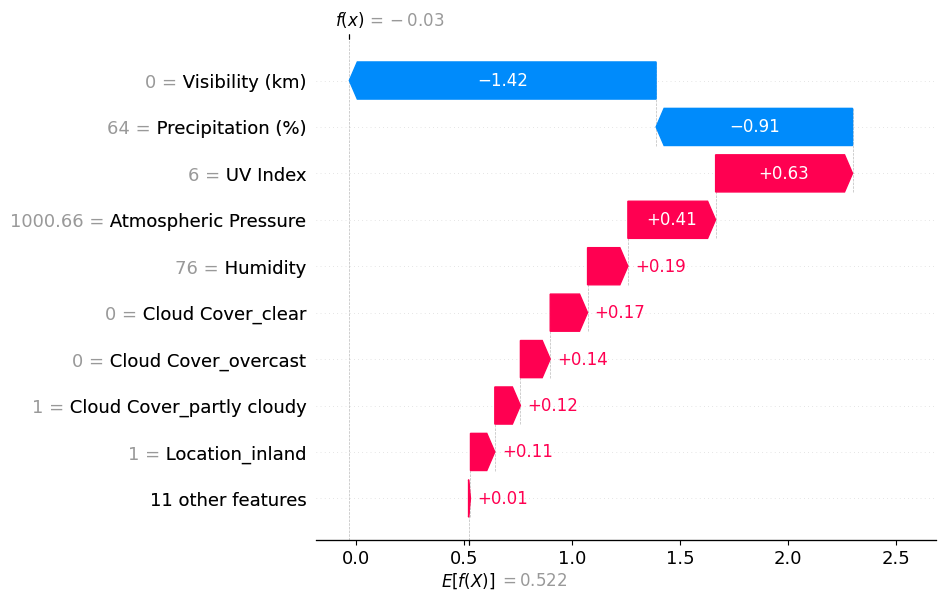

[1.1331347e-05 2.2164437e-04 9.9975771e-01 9.3164854e-06] 2
Waterfall plot for sample 14, class Snowy


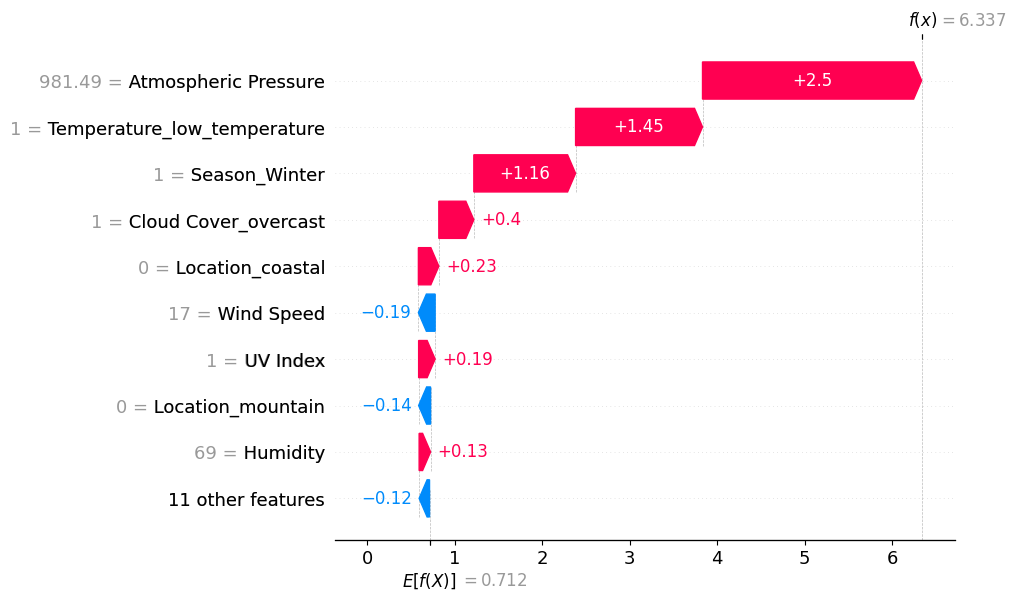

[0.01616385 0.9539908  0.02197548 0.00786985] 1
Waterfall plot for sample 15, class Rainy


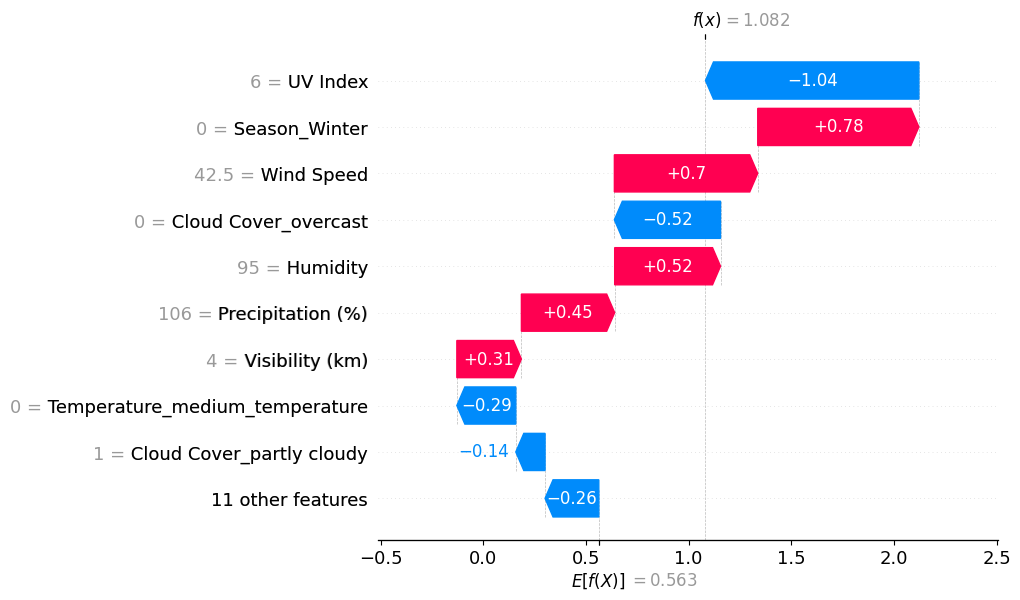

[3.3082662e-04 5.8948131e-05 1.9479858e-05 9.9959081e-01] 3
Waterfall plot for sample 16, class Sunny


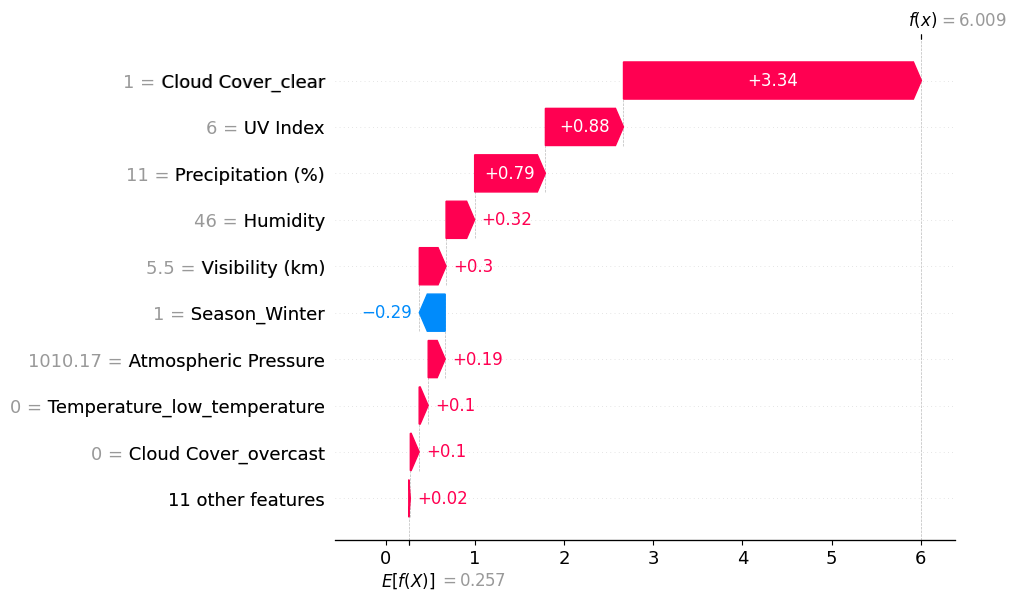

[9.1934745e-04 9.9889356e-01 3.5213245e-05 1.5192831e-04] 1
Waterfall plot for sample 17, class Rainy


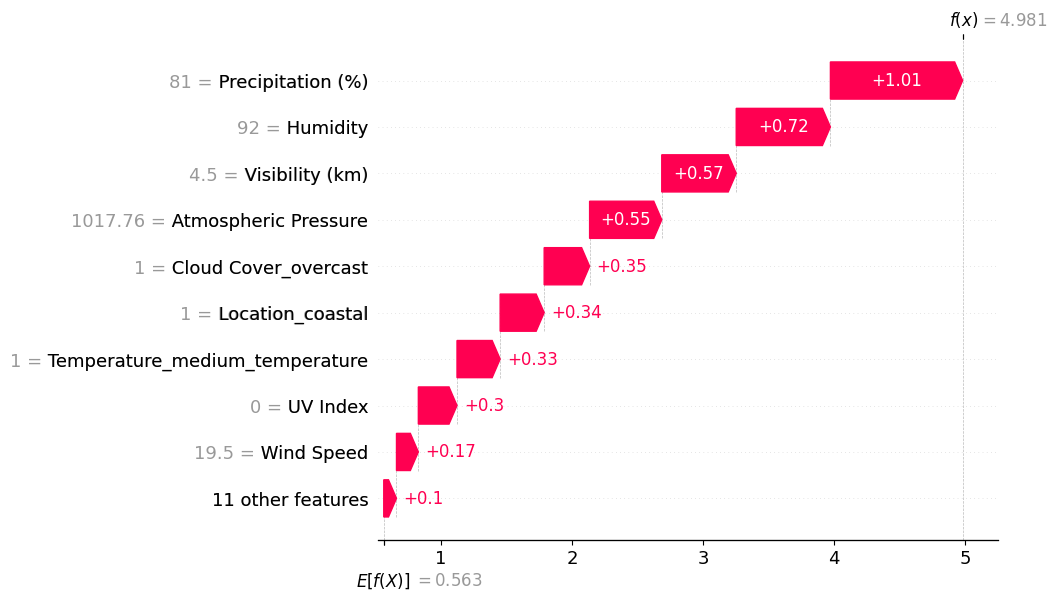

[1.4857683e-05 5.5701359e-05 9.9991751e-01 1.1983267e-05] 2
Waterfall plot for sample 18, class Snowy


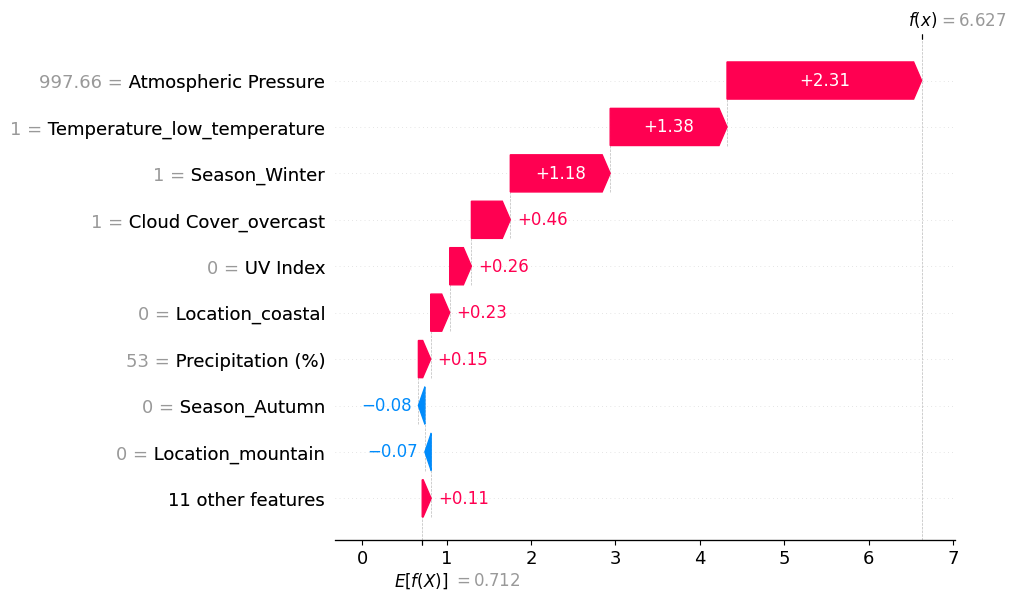

[1.7729533e-04 2.1562748e-05 8.8460816e-05 9.9971265e-01] 3
Waterfall plot for sample 19, class Sunny


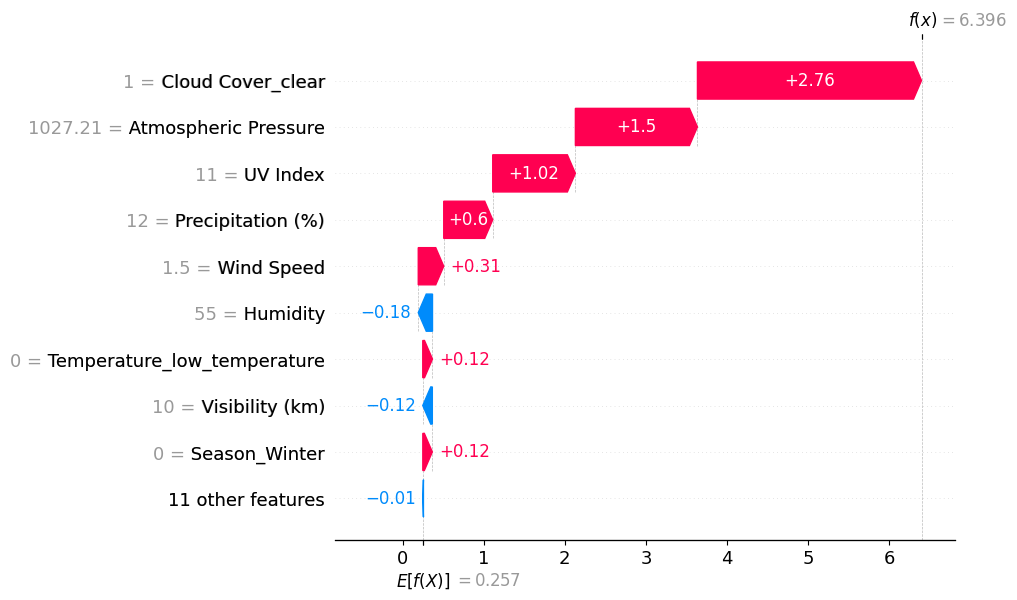

In [14]:
# Finding the index of the class with the highest probability for each sample
max_prob_class_indices = np.argmax(probs, axis=1)

for i, sample in enumerate(X_test[:5]):

    max_class_idx = max_prob_class_indices[i]
    print(probs[i], max_class_idx)
    
    # Extract SHAP values for the class with the highest probability
    shap_values_for_max_class = shap_values.values[i][:, max_class_idx]
    
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature {j}' for j in range(X_test.shape[1])]
    feature_values = X_test.iloc[i] if hasattr(X_test, 'iloc') else X_test[i]
    
    # Prepare SHAP Explanation for this sample
    explanation = shap.Explanation(
        values=shap_values_for_max_class,
        base_values=shap_values.base_values[i][max_class_idx],
        data=feature_values,
        feature_names=feature_names
    )
    
    print(f"Waterfall plot for sample {i}, class {class_labels[max_class_idx]}")
    shap.plots.waterfall(explanation)
    plt.show()


## STEP 3: `PROTOTYPES` - SECOND EXPLANATORY METHOD


In [15]:
explainer = G_KM(model = model_RF_Classifier, n_prototypes = 5)
prototypes = explainer.select_prototypes(X_train_2)
print(prototypes)

{0:       Humidity  Wind Speed  Precipitation (%)  Atmospheric Pressure  UV Index  \
1114        61        10.0               96.0               1174.40        13   
320         82        14.5               96.0               1014.44         8   
716         57         7.0               62.0               1045.58         9   
1303       109        21.0               93.0               1018.98         9   
557         60         7.0               37.0               1009.80         2   

      Visibility (km)  Temperature_low_temperature  \
1114             15.0                            0   
320               7.0                            1   
716              13.5                            1   
1303              7.5                            0   
557               6.0                            0   

      Temperature_medium_temperature  Temperature_high_temperature  \
1114                               1                             0   
320                                0        

In [16]:
# List for storing rows
from copy import deepcopy

prototype_list = []
num_of_rows = 0

for key, prototype in prototypes.items():
    print(f"Prototype {key}:")
    print(prototype.head())

    num_of_rows += len(prototype)
    # Adding a column, so we know which class it is
    prototype_copy = deepcopy(prototype)
    prototype_copy['Class'] = key

    # Appending to the list
    # prototype_list.append(prototype)
    prototype_list.append(prototype_copy)

prototypes_df = pd.concat(prototype_list, ignore_index=True)
prototypes_df.head(num_of_rows)

Prototype 0:
      Humidity  Wind Speed  Precipitation (%)  Atmospheric Pressure  UV Index  \
1114        61        10.0               96.0               1174.40        13   
320         82        14.5               96.0               1014.44         8   
716         57         7.0               62.0               1045.58         9   
1303       109        21.0               93.0               1018.98         9   
557         60         7.0               37.0               1009.80         2   

      Visibility (km)  Temperature_low_temperature  \
1114             15.0                            0   
320               7.0                            1   
716              13.5                            1   
1303              7.5                            0   
557               6.0                            0   

      Temperature_medium_temperature  Temperature_high_temperature  \
1114                               1                             0   
320                                

,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature_low_temperature,Temperature_medium_temperature,Temperature_high_temperature,Cloud Cover_clear,...,Cloud Cover_overcast,Cloud Cover_partly cloudy,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Class
0,61,10.0,96.0,1174.40,13,15.0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
1,82,14.5,96.0,1014.44,8,7.0,1,0,0,0,...,1,0,1,0,0,0,0,1,0,0
2,57,7.0,62.0,1045.58,9,13.5,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
3,109,21.0,93.0,1018.98,9,7.5,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
4,60,7.0,37.0,1009.80,2,6.0,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
5,97,20.5,81.0,1005.35,12,5.5,0,1,0,0,...,1,0,0,1,0,0,1,0,0,1
6,62,5.5,79.0,1012.12,4,5.5,1,0,0,0,...,0,1,0,0,0,1,1,0,0,1
7,76,17.5,106.0,1019.09,2,5.5,1,0,0,0,...,1,0,1,0,0,0,1,0,0,1
8,57,1.5,33.0,1076.91,10,16.0,1,0,0,0,...,0,0,0,0,0,1,1,0,0,1
9,74,0.0,33.0,1171.26,12,13.0,1,0,0,0,...,0,1,0,0,1,0,0,1,0,1


In [17]:
prototypes_df.columns

Index(['Humidity', 'Wind Speed', 'Precipitation (%)', 'Atmospheric Pressure',
       'UV Index', 'Visibility (km)', 'Temperature_low_temperature',
       'Temperature_medium_temperature', 'Temperature_high_temperature',
       'Cloud Cover_clear', 'Cloud Cover_cloudy', 'Cloud Cover_overcast',
       'Cloud Cover_partly cloudy', 'Season_Autumn', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Location_coastal', 'Location_inland',
       'Location_mountain', 'Class'],
      dtype='object')

In [18]:
# DECODING

# list of categories to delete
categories_1 = ['Temperature_low_temperature', 'Temperature_medium_temperature','Temperature_high_temperature']
categories_2 = ['Cloud Cover_clear', 'Cloud Cover_cloudy', 'Cloud Cover_overcast', 'Cloud Cover_partly cloudy']
categories_3 = ['Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter']
categories_4 = ['Location_coastal', 'Location_inland', 'Location_mountain']

def remove_words(main_word, words_to_remove):
    for word in words_to_remove:
        main_word = main_word.replace(word, '')
    return main_word


def decode_one_hot(df, category_columns):
    decoded_labels = []
    for _, row in df[category_columns].iterrows():
        index = row.idxmax()  # Get the column name with the max value (1)
        decoded_labels.append(remove_words(index, ['Temperature_','Cloud Cover_','Season_', 'Location_']))  
    return decoded_labels

# Decoding the specified columns
prototypes_df['Temperature'] = decode_one_hot(prototypes_df, categories_1)
prototypes_df['Cloud Cover_'] = decode_one_hot(prototypes_df, categories_2)
prototypes_df['Season_'] = decode_one_hot(prototypes_df, categories_3)
prototypes_df['Location_'] = decode_one_hot(prototypes_df, categories_4)


# Droping rest columns
prototypes_df =prototypes_df.drop(columns=categories_1+categories_2+categories_3+categories_4)

prototypes_df.head()

,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Class,Temperature,Cloud Cover_,Season_,Location_
0,61,10.0,96.0,1174.40,13,15.0,0,medium_temperature,partly cloudy,Summer,coastal
1,82,14.5,96.0,1014.44,8,7.0,0,low_temperature,overcast,Autumn,inland
2,57,7.0,62.0,1045.58,9,13.5,0,low_temperature,partly cloudy,Winter,inland
3,109,21.0,93.0,1018.98,9,7.5,0,medium_temperature,partly cloudy,Winter,inland
4,60,7.0,37.0,1009.80,2,6.0,0,medium_temperature,partly cloudy,Summer,mountain


In [19]:
X_train_df = deepcopy(X_test_2) 

X_train_df['Temperature'] = decode_one_hot(X_train_df, categories_1)
X_train_df['Cloud Cover_'] = decode_one_hot(X_train_df, categories_2)
X_train_df['Season_'] = decode_one_hot(X_train_df, categories_3)
X_train_df['Location_'] = decode_one_hot(X_train_df, categories_4)

X_balanced_df = X_train_df.drop(columns=categories_1+categories_2+categories_3+categories_4)
X_balanced_df.head()

,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
1860,63,9.0,72.0,1000.61,0,4.0,medium_temperature,overcast,Summer,coastal
353,74,0.0,33.0,1011.20,1,8.0,medium_temperature,partly cloudy,Summer,coastal
1333,91,4.0,56.0,998.74,1,2.5,low_temperature,overcast,Winter,inland
905,71,21.0,86.0,1013.77,12,6.5,medium_temperature,partly cloudy,Winter,inland
1289,63,6.0,80.0,1005.80,0,3.5,medium_temperature,overcast,Winter,coastal


In [20]:
for i in range(100):
    x_0, y_0 = X_test_2.values[i].reshape(1, -1), y_test_2.values[i]  ## class Sunny
    if y_0 == 3:
        max_similarity = 0  
        best_prototype = None
        for _, p in prototypes[y_0].iterrows():
            if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
                max_similarity = pair_similarity
                best_prototype = p

        print("Max similarity: ", max_similarity, i, y_0)

Max similarity:  0.39 6 3
Max similarity:  0.39 16 3
Max similarity:  0.4 19 3
Max similarity:  0 20 3
Max similarity:  0.36 22 3
Max similarity:  0.44 27 3
Max similarity:  0.73 30 3
Max similarity:  0.35 35 3
Max similarity:  0.61 36 3
Max similarity:  0 41 3
Max similarity:  0.39 43 3
Max similarity:  0 51 3
Max similarity:  0.6 53 3
Max similarity:  0.33 58 3
Max similarity:  0.68 60 3
Max similarity:  0.35 63 3
Max similarity:  0.36 72 3
Max similarity:  0.34 73 3
Max similarity:  0.39 80 3
Max similarity:  0.52 83 3
Max similarity:  0.58 84 3
Max similarity:  0.33 87 3
Max similarity:  0.44 97 3
Max similarity:  0.33 99 3


In [21]:
# ['Cloudy' 'Rainy' 'Snowy' 'Sunny']
x_0, y_0 = X_test_2.values[1].reshape(1, -1), y_test_2.values[1]  ## class Cloudy
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[1]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['Humidity']
matching_index = prototypes_df[prototypes_df['Humidity'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

0
Max similarity:  0.56
Humidity                            60.0
Wind Speed                           7.0
Precipitation (%)                   37.0
Atmospheric Pressure              1009.8
UV Index                             2.0
Visibility (km)                      6.0
Temperature_low_temperature          0.0
Temperature_medium_temperature       1.0
Temperature_high_temperature         0.0
Cloud Cover_clear                    0.0
Cloud Cover_cloudy                   0.0
Cloud Cover_overcast                 0.0
Cloud Cover_partly cloudy            1.0
Season_Autumn                        0.0
Season_Spring                        0.0
Season_Summer                        1.0
Season_Winter                        0.0
Location_coastal                     0.0
Location_inland                      0.0
Location_mountain                    1.0
Name: 557, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,74,0.0,33.0,1011.2,1,8.0,medium_temperature,partly cloudy,Summer,coastal
PROTOTYPE,60,7.0,37.0,1009.8,2,6.0,medium_temperature,partly cloudy,Summer,mountain


In [22]:
# ['Cloudy' 'Rainy' 'Snowy' 'Sunny']
x_0, y_0 = X_test_2.values[66].reshape(1, -1), y_test_2.values[66]  ## class Rainy
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[66]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['UV Index']
matching_index = prototypes_df[prototypes_df['UV Index'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

1
Max similarity:  0.19
Humidity                            76.00
Wind Speed                          17.50
Precipitation (%)                  106.00
Atmospheric Pressure              1019.09
UV Index                             2.00
Visibility (km)                      5.50
Temperature_low_temperature          1.00
Temperature_medium_temperature       0.00
Temperature_high_temperature         0.00
Cloud Cover_clear                    0.00
Cloud Cover_cloudy                   0.00
Cloud Cover_overcast                 1.00
Cloud Cover_partly cloudy            0.00
Season_Autumn                        1.00
Season_Spring                        0.00
Season_Summer                        0.00
Season_Winter                        0.00
Location_coastal                     1.00
Location_inland                      0.00
Location_mountain                    0.00
Name: 940, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,79,15.0,71.0,1012.93,2,1.5,low_temperature,overcast,Spring,coastal
PROTOTYPE,60,7.0,37.0,1009.80,2,6.0,medium_temperature,partly cloudy,Summer,mountain


In [23]:
# ['Cloudy' 'Rainy' 'Snowy' 'Sunny']
x_0, y_0 = X_test_2.values[32].reshape(1, -1), y_test_2.values[32]  ## class Snowy
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[32]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['Humidity']
matching_index = prototypes_df[prototypes_df['Humidity'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

2
Max similarity:  0.54
Humidity                          101.0
Wind Speed                         28.0
Precipitation (%)                  84.0
Atmospheric Pressure              991.4
UV Index                           11.0
Visibility (km)                     6.0
Temperature_low_temperature         1.0
Temperature_medium_temperature      0.0
Temperature_high_temperature        0.0
Cloud Cover_clear                   0.0
Cloud Cover_cloudy                  0.0
Cloud Cover_overcast                1.0
Cloud Cover_partly cloudy           0.0
Season_Autumn                       0.0
Season_Spring                       0.0
Season_Summer                       0.0
Season_Winter                       1.0
Location_coastal                    0.0
Location_inland                     0.0
Location_mountain                   1.0
Name: 1067, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,102,18.0,93.0,984.22,9,5.5,low_temperature,overcast,Winter,inland
PROTOTYPE,101,28.0,84.0,991.40,11,6.0,low_temperature,overcast,Winter,mountain


In [24]:
# ['Cloudy' 'Rainy' 'Snowy' 'Sunny']
x_0, y_0 = X_test_2.values[30].reshape(1, -1), y_test_2.values[30]  ## class Sunny
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[30]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['Humidity']
matching_index = prototypes_df[prototypes_df['Humidity'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

3
Max similarity:  0.73
Humidity                            36.00
Wind Speed                           0.50
Precipitation (%)                   13.00
Atmospheric Pressure              1012.36
UV Index                             5.00
Visibility (km)                      5.50
Temperature_low_temperature          0.00
Temperature_medium_temperature       1.00
Temperature_high_temperature         0.00
Cloud Cover_clear                    0.00
Cloud Cover_cloudy                   0.00
Cloud Cover_overcast                 0.00
Cloud Cover_partly cloudy            1.00
Season_Autumn                        0.00
Season_Spring                        1.00
Season_Summer                        0.00
Season_Winter                        0.00
Location_coastal                     0.00
Location_inland                      1.00
Location_mountain                    0.00
Name: 836, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,40,7.0,5.0,1013.66,9,9.5,medium_temperature,partly cloudy,Summer,inland
PROTOTYPE,36,0.5,13.0,1012.36,5,5.5,medium_temperature,partly cloudy,Spring,inland


In [25]:
# ['Cloudy' 'Rainy' 'Snowy' 'Sunny']
x_0, y_0 = X_test_2.values[60].reshape(1, -1), y_test_2.values[60]  ## class Sunny
print(y_0)
max_similarity = 0  
best_prototype = None
for _, p in prototypes[y_0].iterrows():
    if (pair_similarity := explainer.pair_similarity(x_0, p)) > max_similarity:
        max_similarity = pair_similarity
        best_prototype = p

print("Max similarity: ", max_similarity)
print(best_prototype)

X = X_balanced_df.iloc[[60]].copy()
# X['Class'] = y_0
daily_rate_to_match = best_prototype['Humidity']
matching_index = prototypes_df[prototypes_df['Humidity'] == daily_rate_to_match].index[0]
prototypes_df_cleaned = prototypes_df.iloc[[matching_index]].drop(columns=['Class'])
combined_df = pd.concat([X, prototypes_df_cleaned], axis=0)
combined_df.index = ['INSTANCE', 'PROTOTYPE']
combined_df

3
Max similarity:  0.68
Humidity                            36.00
Wind Speed                           0.50
Precipitation (%)                   13.00
Atmospheric Pressure              1012.36
UV Index                             5.00
Visibility (km)                      5.50
Temperature_low_temperature          0.00
Temperature_medium_temperature       1.00
Temperature_high_temperature         0.00
Cloud Cover_clear                    0.00
Cloud Cover_cloudy                   0.00
Cloud Cover_overcast                 0.00
Cloud Cover_partly cloudy            1.00
Season_Autumn                        0.00
Season_Spring                        1.00
Season_Summer                        0.00
Season_Winter                        0.00
Location_coastal                     0.00
Location_inland                      1.00
Location_mountain                    0.00
Name: 836, dtype: float64


,Humidity,Wind Speed,Precipitation (%),Atmospheric Pressure,UV Index,Visibility (km),Temperature,Cloud Cover_,Season_,Location_
INSTANCE,45,3.5,14.0,1024.65,7,8.0,medium_temperature,partly cloudy,Spring,mountain
PROTOTYPE,36,0.5,13.0,1012.36,5,5.5,medium_temperature,partly cloudy,Spring,inland
